## P.S. このノートブックの背景にある主なアイデアは、FabienDaniel Kernel Elo_worldからヒントを得たものです。
https://www.kaggle.com/fabiendaniel/elo-world

まずはデータ説明から


In [1]:
import numpy as np 
import pandas as pd 
#可視化系
import matplotlib.pyplot as plt
import seaborn as sns
#機械学習
import lightgbm as lgb
from sklearn.model_selection import KFold
#よく見るけど未だわからん
import warnings
import time
#osと同じ　メモリ使用量とかも見れる
import sys
import datetime
#可視化　ダブってね？
import matplotlib.pyplot as plt
import seaborn as sns
#RMSE出すために使う
from sklearn.metrics import mean_squared_error
#サイキットラーンで使う（回帰？ナイーフベイズ？）
from sklearn.linear_model import BayesianRidge
#warningとセットで見る
warnings.simplefilter(action='ignore', category=FutureWarning)
#ガベージコレクション
import gc

## 本カーネルには記述してないがデータの説明<br>(trainとtestは少し後で解説してます)
<br>コンペデータ一覧
<br>
<br>Data_Dictionary.xlsx
<br>　各々のデータの説明を記述してるエクセルファイル
<br>merchants.csv(本カーネルではなぜか不使用)(データセット内のすべての販売側IDに関する追加情報。)
<br>　クレカ登録店舗の一覧及びデータ
<br>historical_transactions.csv
<br>　クレカ取引履歴　(各card_idについて最大3か月分の過去の取引)
<br>new_merchant_transactions.csv　
<br>　(上記履歴データでは訪問されなかったmerchant_idで行われたすべての購入を含む、各card_idの2か月分のデータ。)
<br>　販売側の新規取引履歴（クレカ側のデータではなく販売店側のデータなのでは？）
<br>train.csv
<br>　トレーニングデータ　顧客のIDとカテゴリ分けがされてる
<br>test.csv
<br>　テストデータ　同上
<br>sample_submission.csv
<br>　予測結果を書き込む所
<br><br><br>
Elo_Blending=予測精度を上げる為に用意したデータ
<br><br>
過去に予測したデータが色々入ってる

In [2]:
#このカーネルでは使ってないけれど一応読み込み　解説
merchants = pd.read_csv('../input/elo-merchant-category-recommendation/merchants.csv')
merchants.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,9.666667,3,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,1.750000,3,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,260.000000,2,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,1.666667,3,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,0.500000,3,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


## ↑merchants.csv クレカ登録店舗の一覧及びデータ
<br>merchant_id＝販売者ID　M_ID_から始まる英数字
<br>merchant_group_id=販売者グループ　1~113kまである
<br>merchant_category_id＝販売者カテゴリ　-1~891まで（-1は多分不明）
<br>subsector_id=販売者カテゴリグループ　-1~41まで(merchant_category_idより狭い)
<br>
<br>city_id	＝市ID　-1~347 -1は不明？
<br>state_id＝国ID　-1~24 -1は不明？
<br>
<br>numerical_1=指標　-0.06前後が多いが184（null?）もある
<br>numerical_2=指標　同上だが184でなく182(null？)
<br>
<br>category_1=カテゴリ　N98%Y2%
<br>category_2　1~5
<br>category_4=カテゴリ N71%Y29%
<br>
<br>most_recent_sales_range=先月の収益の範囲（通貨単位） - > A> B> C> D 35%> E 53%の５段階評価(基準分からず)
<br>most_recent_purchases_range=前月の取引量の範囲 - > A> B> C> D 36%> E 52%の５段階評価(基準分からず)
<br>avg_sales_lag3=3ヶ月移動平均収益　-82.13~9k（直近3ヶ月間の収益を直近のアクティブな月の売上で割った月平均）
<br>avg_purchases_lag3=3ヶ月移動平均取引　0.3~99(過去3か月の取引の月平均を前のアクティブ月のトランザクションで割ったもの)
<br>active_months_lag3=過去3ヶ月で取引があった月の数 1~3
<br>
<br>avg_sales_lag6=6ヶ月移動平均収益　（直近の6ヶ月間の収益を直近のアクティブな月の売上で割った月平均）
<br>avg_purchases_lag6=6ヶ月移動平均取引　（過去6か月のトランザクションの月平均を前のアクティブ月のトランザクションで割ったもの）
<br>active_months_lag6=過去6ヶ月で取引があった月の数
<br>
<br>avg_sales_lag12=12ヶ月移動平均収益　（直近の12ヶ月の売上を直近の有効月の売上で割った月平均）
<br>avg_purchases_lag12=12ヶ月移動平均取引（過去12か月間のトランザクションの月平均を、直前のアクティブ月のトランザクションで割ったもの）
<br>active_months_lag12=過去12か月で取引があった月の数

In [3]:
#データ読み込み parse_dateは指定したカラムをタイムスタンプ型として読み込む　今回はperchase_date=購入日を使用している
new_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('../input/elo-merchant-category-recommendation/historical_transactions.csv', parse_dates=['purchase_date'])
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


## ↑new_merchant_transactions.csv 販売側の新規取引履歴
<br>card_id＝カードID
<br>month_lag＝基準日(2018年2月？）までの月差
<br>purchase_date＝購入日
<br>
<br>authorized_flag＝取引完了フラグ　（承認された場合はY、拒否された場合はN）
<br>
<br>category_1＝カテゴリ　N97%　Y3%
<br>category_2＝カテゴリ　1～5
<br>category_3＝カテゴリ　A47％　B43%
<br>
<br>installments＝購入の分割数　－１～９９９（９９９回分割は不正取引ぽい）
<br>
<br>merchant_category_id＝販売者カテゴリID
<br>subsector_id＝販売者カテゴリグループID
<br>merchant_id＝販売者ID
<br>
<br>purchase_amount＝購入量
<br>
<br>city_id＝市ID
<br>state_id＝州ID

In [4]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


## ↑historical_transactions.csv	クレカ取引履歴
###new_merchant_transactions.csv 販売側の新規取引履歴とカラム内容は同じ
<br>card_id=カード識別子
<br>month_lag=基準日(2018年2月？）までの月差
<br>purchase_date=購入日
<br>authorized_flag=カード決済完了率　完了したらY、失敗したらN
<br>category_3=カテゴリ　A~C
<br>installments=購入の分割数
<br>category_1=カテゴリ　YかN
<br>merchant_category_id=販売者カテゴリID
<br>subsector_id=販売者カテゴリグループID
<br>merchant_id=販売者ID
<br>purchase_amount=購入量
<br>city_id=市ID
<br>state_id=州ID
<br>category_2=カテゴリ　１～４

In [5]:
#メモリ使用量を減らす関数を定義
def reduce_mem_usage(df, verbose=True):
    #型宣言
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    #メモリの消費割合を格納
    start_mem = df.memory_usage().sum() / 1024**2
    #カラム名を一つずつ引っ張ってくる
    for col in df.columns:
        #カラムの型をcol_typeに代入
        col_type = df[col].dtypes
        #型が数字だったら
        if col_type in numerics:
            #c_minの最低値をc_maxに最大値を入れる
            c_min = df[col].min()
            c_max = df[col].max()
            #型名の最初3文字がint~型だったら
            if str(col_type)[:3] == 'int':
                #c_minがint8の数値範囲にあればint8型で格納する
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                #同様にint16で    
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                #同様にint32    
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                #同様にint64    
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #同様にfloat16
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                #同様にfloat32    
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    #同様にfloat64
                    df[col] = df[col].astype(np.float64)    
    #メモリの消費割合の算出
    end_mem = df.memory_usage().sum() / 1024**2
    #算出？？？？わからん
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
#authorized_flag 決済完遂フラグとカテゴリ１　カラムをダミー変数化
#こっちはメソッド作り　Yを１　Nを０に置換
def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df
#new_merchant_transactions.csv(販売側の新規取引履歴)
#とhistorical_transactions.csv(カード会社側取引履歴)を上のメソッドでダミー変数化
historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [7]:
%%time
#↑はメモリ使用量計測
#trainデータの整形メソッド
def read_data(input_file):
    #csvをdfに格納
    df = pd.read_csv(input_file)
    #trainデータの初購入月(first_active_month) をタイムスタンプ型に変換
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    # 2018年2月1日(基準日っぽい)ー初購入月(first_active_month)の日付　で日付だけをelapsed_timeに格納
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df
#trainデータとtestデータの読み込み
train = read_data('../input/elo-merchant-category-recommendation/train.csv')
test = read_data('../input/elo-merchant-category-recommendation/test.csv')
#trainデータのtarget　　　　　　　　　履歴および評価期間の2ヶ月後に算出された
#　　　　　　　　　　　　　　　　　　　ロイヤリティ数値スコア？？をtarget変数に格納して

target = train['target']
#trainデータのtargetカラムは削除している
del train['target']
#ガベージコレクション
gc.collect()

CPU times: user 1.74 s, sys: 8 ms, total: 1.75 s
Wall time: 1.76 s


In [8]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


## train.csv トレーニングデータ =　test.csv テストデータ
<br>
<br>#card_id　　　　　　　　カードID　　　　
<br>#first_active_month　　初購入月　　　　
<br>#feature_1            　　匿名カードの分類機能(ゴールド会員？)
<br>#feature_2　　　　　　３段階に分かれている
<br>#feature_3
<br>#elapsed_time　　　　2018年2月1日から初購入月が何日前か

## フィーチャーエンジニアリング（特徴量創出）

In [9]:
%%time
#historical_transactions.csv	クレカ取引履歴のカテゴリ２と３をダミー変数化する
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])

CPU times: user 6.71 s, sys: 5.95 s, total: 12.7 s
Wall time: 12.7 s


In [10]:
#category_2_1.0やcategory_3_Aができて０か１が入っている
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [11]:
#上記と同様にnew_merchant_transactions.csv 販売側の新規取引履歴のカテゴリ２と３
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

In [12]:
new_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_415bb3a509,107,0,1,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,9,19,1,0,0,0,0,0,1,0
1,1,C_ID_415bb3a509,140,0,1,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,9,19,1,0,0,0,0,0,1,0
2,1,C_ID_415bb3a509,330,0,1,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,9,14,1,0,0,0,0,0,1,0
3,1,C_ID_415bb3a509,-1,1,1,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,-1,8,0,0,0,0,0,0,1,0
4,1,C_ID_ef55cf8d4b,-1,1,1,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,-1,29,0,0,0,0,0,0,1,0


In [13]:
#historical_transactionsとnew_transactionsをメモリ使用量を減らすメソッドにかけてる
historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)
#メモリー使用量が1304Mb減少(54.8%)　newは84.24Mb

Mem. usage decreased to 1304.89 Mb (54.8% reduction)
Mem. usage decreased to 84.24 Mb (56.7% reduction)


In [14]:
#クレカ取引履歴(historical_transactions.csv)の
#authorized_flag=カード決済完了フラグの合計と平均をagg_fun変数に格納
agg_fun = {'authorized_flag': ['sum', 'mean']}
#そのagg_funを使って　クレカ取引履歴(historical_transactions.csv)のカードID(card_id)を主キーとして
#グループバイ
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)

In [15]:
auth_mean.head()

authorized_flag          
                            sum      mean
card_id                                  
C_ID_00007093c1           114.0  0.765101
C_ID_0001238066           120.0  0.975610
C_ID_0001506ef0            62.0  0.939394
C_ID_0001793786           189.0  0.875000
C_ID_000183fdda           137.0  0.951389

In [16]:
#上記のカラム名を引っ張ってきて　stripで空白削除して_でタイトルと結合
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.head()

,authorized_flag_sum,authorized_flag_mean
card_id,,
C_ID_00007093c1,114.0,0.765101
C_ID_0001238066,120.0,0.975610
C_ID_0001506ef0,62.0,0.939394
C_ID_0001793786,189.0,0.875000
C_ID_000183fdda,137.0,0.951389


In [17]:
#リセットインデックス（番号を↑から降りなおし）
auth_mean.reset_index(inplace=True)
auth_mean.head()

,card_id,authorized_flag_sum,authorized_flag_mean
0,C_ID_00007093c1,114.0,0.765101
1,C_ID_0001238066,120.0,0.975610
2,C_ID_0001506ef0,62.0,0.939394
3,C_ID_0001793786,189.0,0.875000
4,C_ID_000183fdda,137.0,0.951389


In [18]:
#authorized_flag=カード決済完了フラグが
#完了の１をauthorized_transaxtionsへ
#失敗の０をhistorical_transaxtionsに分けてデータ格納
authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]
#ガベージコレクション
gc.collect()

83

In [19]:
authorized_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
0,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,16,37,1,0,0,0,0,1,0,0
1,1,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,16,16,1,0,0,0,0,1,0,0
2,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,16,37,1,0,0,0,0,1,0,0
3,1,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,16,34,1,0,0,0,0,1,0,0
4,1,C_ID_4e6213e9bc,88,0,0,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,16,37,1,0,0,0,0,1,0,0


In [20]:
historical_transactions.head()

,authorized_flag,card_id,city_id,category_1,installments,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,state_id,subsector_id,category_2_1.0,category_2_2.0,category_2_3.0,category_2_4.0,category_2_5.0,category_3_A,category_3_B,category_3_C
115,0,C_ID_4e6213e9bc,88,0,0,842,M_ID_22c9cfa265,-10,-0.730379,2017-04-07 12:58:09,16,37,1,0,0,0,0,1,0,0
132,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:27,16,16,1,0,0,0,0,1,0,0
148,0,C_ID_4e6213e9bc,88,0,0,367,M_ID_86ec983688,-5,-0.723782,2017-09-17 22:40:26,16,16,1,0,0,0,0,1,0,0
168,0,C_ID_4e6213e9bc,333,0,0,605,M_ID_c2ae34c2ef,0,-0.664262,2018-02-20 10:57:50,9,2,1,0,0,0,0,1,0,0
213,0,C_ID_4e6213e9bc,88,0,0,560,M_ID_e6d5ae8ea6,-7,-0.738132,2017-07-08 07:33:31,16,34,1,0,0,0,0,1,0,0


In [21]:
%%time
#上記の２つのデータの購入日(purchase_date)の月だけを抜き出して購入月(purchase_month)作成
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
#new_merchant_transactions.csv(販売側の新規取引履歴)も購入日から購入月作成
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month
#ガベージコレクション
gc.collect()

CPU times: user 1.88 s, sys: 260 ms, total: 2.14 s
Wall time: 2.14 s


In [22]:
%%time
def aggregate_transactions(history):
    #purchase_dateを時系列のインデックスとしてint64に型変換してるだろうというのはわかるが
    #1e-9=0.000000001がわからない（9桁で表示とか？）
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).\
                                      astype(np.int64) * 1e-9
    #agg_func変数に作成したい項目を追加(np.ptpは値の範囲？)
    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }
    #引数の渡されたデータをagg_funncにカードID(card_id)を主キーにしてグループバイ
    agg_history = history.groupby(['card_id']).agg(agg_func)
    #カラム名をタイトルと結合
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    #リセットインデックス
    agg_history.reset_index(inplace=True)
    
    #カードID(card_id)グループバイしたのをsizeで要素数？？？を取得して
    #リセットインデックス(transactions_count)という項目名で
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    #agg_historyに上記のdfとその上のagg_historyをカードIDで外部結合する
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    #agg_historyを返す
    return agg_history
#ガベージコレクション
gc.collect()

CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 76.4 ms


In [23]:
%%time
#上記のメソッドをクレカ取引履歴(historical_transactions.csv)にかけてる
history = aggregate_transactions(historical_transactions)

CPU times: user 52.9 s, sys: 496 ms, total: 53.4 s
Wall time: 53.4 s


In [24]:
history.head()
#正直transactions_countとpurchase_dateがなんでこうなってるのか
#未だ分かりません・・・

,card_id,transactions_count,category_1_sum,category_1_mean,category_2_1.0_mean,category_2_2.0_mean,category_2_3.0_mean,category_2_4.0_mean,category_2_5.0_mean,category_3_A_mean,category_3_B_mean,category_3_C_mean,merchant_id_nunique,merchant_category_id_nunique,state_id_nunique,city_id_nunique,subsector_id_nunique,purchase_amount_sum,purchase_amount_mean,purchase_amount_max,purchase_amount_min,purchase_amount_std,installments_sum,installments_mean,installments_max,installments_min,installments_std,purchase_month_mean,purchase_month_max,purchase_month_min,purchase_month_std,purchase_date_ptp,purchase_date_min,purchase_date_max,month_lag_min,month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [25]:
#分かり辛いが　カードID(card_id）以外のカラム名の先頭にhist_をつける
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]

In [26]:
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,0.828571,0.171429,11,8,2,3,7,-14.401965,-0.411485,1.507069,-0.728876,0.430059,45,1.285714,3,1,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,1.000000,0.000000,2,1,2,2,1,-1.789928,-0.596643,-0.596643,-0.596643,0.000000,3,1.000000,1,1,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,0.250000,0.000000,4,4,1,1,4,-2.905782,-0.726445,-0.708590,-0.740491,0.016203,1,0.250000,1,0,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,0.185185,0.000000,17,14,4,8,11,-11.825338,-0.437975,1.236592,-0.745405,0.498150,5,0.185185,1,0,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.428571,0.571429,4,4,1,1,4,-0.941381,-0.134483,0.334099,-0.714541,0.452741,19,2.714286,6,1,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [27]:
#ガベージコレクション
gc.collect()

232

In [28]:
%%time
#上記と同じ事をカード決済完了フラグが完了になっていたデータで行う
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]
gc.collect()

CPU times: user 2min 52s, sys: 9.98 s, total: 3min 2s
Wall time: 3min 2s


In [29]:
%%time
#上のaggregate_transactionsメソッドを#new_merchant_transactions.csv(販売側の新規取引履歴)にかけてる
new = aggregate_transactions(new_transactions)
#上記のauth_をnew_にしてるだけ
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
gc.collect()

CPU times: user 53.9 s, sys: 216 ms, total: 54.1 s
Wall time: 54.1 s


In [31]:
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,1.000000,0.000000,2,2,2,2,2,-1.328125,-0.664062,-0.656738,-0.671875,0.010704,2,1.000000,1,1,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,0.807692,0.153846,25,15,4,8,9,-14.851562,-0.571289,-0.078308,-0.740723,0.173462,42,1.615385,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,0.000000,0.000000,1,2,1,1,2,-1.447266,-0.723633,-0.715332,-0.731934,0.011742,0,0.000000,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,0.000000,0.000000,31,21,5,7,14,-0.229004,-0.007385,3.130859,-0.737793,0.947266,0,0.000000,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,0.545455,0.363636,11,9,2,2,6,-6.589844,-0.599121,-0.107666,-0.732422,0.182861,16,1.454545,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


In [30]:
%%time

def aggregate_per_month(history):
    #渡されたデータのカードID(card_id)とmonth_lag=基準日(2018年2月？）までの月差でグループバイ
    grouped = history.groupby(['card_id', 'month_lag'])

    #agg_funcに欲しい式情報を入れてる
    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }
    #上記のagg_funkをかけてる
    intermediate_group = grouped.agg(agg_func)
    #カラム名を空白削除と先頭にタイトル名_の形で結合
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    #リセットインデックス
    intermediate_group.reset_index(inplace=True)
    #上記のデータをカードID(card_id)の平均と標準偏差でグループバイ
    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    #カラム名を同様に変更
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    #この値を返す
    return final_group
#___________________________________________________________
#historical_transactions.csv	クレカ取引履歴を上記のメソッドにかける
final_group =  aggregate_per_month(historical_transactions) 
#１０行表示
gc.collect()

CPU times: user 3.29 s, sys: 168 ms, total: 3.46 s
Wall time: 3.5 s


In [32]:
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,0.156374,-0.215325,0.617379,0.273154,0.389389,2.916667,1.621354,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,0.000000,-0.596643,0.000000,0.000000,NaN,1.500000,0.707107,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,0.013464,-0.729642,0.018235,0.005844,NaN,1.333333,0.577350,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,0.054207,-0.139516,0.689409,0.278960,0.358014,4.500000,1.974842,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,0.190682,-0.190221,0.741501,0.409220,NaN,3.500000,3.535534,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,0.206594,-0.501372,0.464043,0.100062,0.183985,2.428571,1.397276,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,0.163608,-0.578761,0.154732,0.087996,NaN,1.500000,1.000000,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,0.002568,-0.738228,0.002957,0.002394,0.001692,3.600000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,-0.617958,0.093896,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,0.086498,-0.597637,0.136971,0.037378,0.074756,2.500000,1.516575,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


# 今まで作成したデータをtrain(及びtest)データに結合

In [33]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time
0,2017-06-01,C_ID_92a2005557,5,2,1,245
1,2017-01-01,C_ID_3d0044924f,4,1,0,396
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549
3,2017-09-01,C_ID_186d6a6901,4,3,0,153
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92


クレカ取引履歴(historical_transactions.csv)のカード決済完了フラグが失敗だったデータの
<br>取引回数、カテゴリ１の合計平均、カテゴリ２の平均、カテゴリ３の平均、購入量の合計平均最大最小標準偏差
<br>分割回数の合計平均最大最小標準偏差、購入月の平均最小標準偏差、購入日の範囲最小最大、何日前購入の最小最大
<br>を追加

In [35]:
#trainデータとhistorical_transactions.csv	クレカ取引履歴整形後の
#決済完了フラグが失敗だったデータをカードID(card_id)で左外部結合
#testデータも
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

In [36]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,-2.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,-1.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,-10.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,5.0,3.0,0.600000,0.000000,0.0,0.0,0.4,0.0,0.000000,0.400000,0.600000,2.0,2.0,2.0,2.0,2.0,20.352808,4.070562,7.193041,-0.512945,4.184950,38.0,7.600000,12.0,1.0,6.024948,1.600000,2.0,1.0,0.547723,3274330.0,1.516485e+09,1.519759e+09,-1.0,0.0


クレカ取引履歴(historical_transactions.csv)のカード決済完了フラグが成功だったデータの
<br>取引回数、カテゴリ１の合計平均、カテゴリ２の平均、カテゴリ３の平均、購入量の合計平均最大最小標準偏差
<br>分割回数の合計平均最大最小標準偏差、購入月の平均最小標準偏差、購入日の範囲最小最大、何日前購入の最小最大
<br>を追加

In [37]:
#trainデータとhistorical_transactions.csv	クレカ取引履歴整形後の
#決済完了フラグが完了だったデータをカードID(card_id)で左外部結合
#testデータも
train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

In [38]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,auth_category_3_B_mean,auth_category_3_C_mean,auth_merchant_id_nunique,auth_merchant_category_id_nunique,auth_state_id_nunique,auth_city_id_nunique,auth_subsector_id_nunique,auth_purchase_amount_sum,auth_purchase_amount_mean,auth_purchase_amount_max,auth_purchase_amount_min,auth_purchase_amount_std,auth_installments_sum,auth_installments_mean,auth_installments_max,auth_installments_min,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,-2.0,247,0.0,0.000000,0.987854,0.0,0.0,0.000000,0.012146,1.0,0.000000,0.000000,93,41,3,7,21,-157.397018,-0.637235,2.258394,-0.739395,0.216518,0,0.000000,0,0,0.000000,7.979757,12,1,3.528570,20977987.0,1.498573e+09,1.519551e+09,-8,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,-1.0,339,29.0,0.085546,0.914454,0.0,0.0,0.000000,0.000000,0.0,0.802360,0.191740,141,57,3,9,24,-208.883453,-0.616175,4.630300,-0.742400,0.355554,501,1.477876,10,-1,1.350634,6.144543,12,1,3.859177,33717687.0,1.483720e+09,1.517438e+09,-12,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,-10.0,41,0.0,0.000000,0.097561,0.0,0.0,0.000000,0.902439,1.0,0.000000,0.000000,13,8,2,5,7,-27.828424,-0.678742,-0.145847,-0.730138,0.089230,0,0.000000,0,0,0.000000,4.634146,12,1,3.329836,35635623.0,1.484123e+09,1.519759e+09,-13,0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77,12.0,0.155844,0.155844,0.0,0.0,0.688312,0.000000,0.0,0.883117,0.090909,50,25,5,7,13,-49.491364,-0.642745,1.445596,-0.740897,0.261624,84,1.090909,3,-1,0.588974,7.740260,12,1,3.904797,13375339.0,1.506443e+09,1.519818e+09,-5,0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,5.0,3.0,0.600000,0.000000,0.0,0.0,0.4,0.0,0.000000,0.400000,0.600000,2.0,2.0,2.0,2.0,2.0,20.352808,4.070562,7.193041,-0.512945,4.184950,38.0,7.600000,12.0,1.0,6.024948,1.600000,2.0,1.0,0.547723,3274330.0,1.516485e+09,1.519759e+09,-1.0,0.0,128,12.0,0.093750,0.078125,0.0,0.0,0.820312,0.007812,0.0,0

new_merchant_transactions.csv(販売側の新規取引履歴)
<br>取引回数、カテゴリ１の合計平均、カテゴリ２の平均、カテゴリ３の平均、購入量の合計平均最大最小標準偏差
<br>分割回数の合計平均最大最小標準偏差、購入月の平均最小標準偏差、購入日の範囲最小最大、何日前購入の最小最大
<br>を追加

In [39]:
#trainデータとnew_merchant_transactions.csv(販売側の新規取引履歴)を左外部結合
#testデータも
train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

In [40]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,...,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,new_category_3_B_mean,new_category_3_C_mean,new_merchant_id_nunique,new_merchant_category_id_nunique,new_state_id_nunique,new_city_id_nunique,new_subsector_id_nunique,new_purchase_amount_sum,new_purchase_amount_mean,new_purchase_amount_max,new_purchase_amount_min,new_purchase_amount_std,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,...,20977987.0,1.498573e+09,1.519551e+09,-8,0,23.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,0.000000,23.0,14.0,1.0,3.0,10.0,-13.242188,-0.575684,-0.296143,-0.724609,0.135742,0.0,0.000000,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,4742309.0,1.520259e+09,1.525001e+09,1.0,2.0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,...,33717687.0,1.483720e+09,1.517438e+09,-12,0,6.0,0.0,0.000000,1.000000,0.0,0.000000,0.000000,0.0,0.0,1.000000,0.000000,6.0,5.0,1.0,1.0,4.0,-4.355469,-0.726074,-0.701660,-0.739258,0.014381,6.0,1.000000,1.0,1.0,0.000000,2.500000,3.0,2.0,0.547723,4887632.0,1.517505e+09,1.522393e+09,1.0,2.0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,...,35635623.0,1.484123e+09,1.519759e+09,-13,0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,1.0,1.0,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-0.700195,-0.700195,-0.700195,-0.700195,NaN,0.0,0.000000,0.0,0.0,NaN,4.000000,4.0,4.0,NaN,0.0,1.524937e+09,1.524937e+09,2.0,2.0
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13375339.0,1.506443e+09,1.519818e+09,-5,0,7.0,1.0,0.142857,0.000000,0.0,0.000000,0.857143,0.0,0.0,0.857143,0.000000,7.0,6.0,2.0,2.0,5.0,-4.656250,-0.665039,-0.566895,-0.734375,0.065918,5.0,0.714286,1.0,-1.0,0.755929,3.714286,4.0,3.0,0.487950,3625505.0,1.520424e+09,1.524049e+09,1.0,2.0
4,2017-11-01,C_ID_cdbd2c0db2,1,3,0,92,5.0,3.0,0.600000,0.000000,0

### historical_transactions.csv	クレカ取引履歴の購入量(purchase_amount) と分割回数の
### レコード数、合計、平均、最小値、最大、標準偏差のカラム毎のカードID毎の平均と標準偏差を追加

In [41]:
#trainデータに上記で算出したfinal_groupを左外部結合
train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

In [42]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,...,new_installments_sum,new_installments_mean,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,...,0.0,0.000000,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,4742309.0,1.520259e+09,1.525001e+09,1.0,2.0,-4.500000,1.870829,2.166667,1.169045,-1.428621,0.882324,-0.637972,0.119344,-0.664760,0.118497,-0.608962,0.127612,0.051078,0.050203,2.166667,1.169045,0.666667,0.816497,0.319444,0.423007,0.166667,0.408248,0.5,0.547723,0.269338,0.312603
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,...,6.0,1.000000,1.0,1.0,0.000000,2.500000,3.0,2.0,0.547723,4887632.0,1.517505e+09,1.522393e+09,1.0,2.0,-5.333333,3.326660,1.833333,1.602082,-0.187148,0.759414,-0.148523,0.438508,-0.292969,0.471576,0.154320,0.970537,0.535838,0.757790,1.833333,1.602082,7.000000,7.641989,4.033333,3.522310,3.500000,3.728270,5.0,4.289522,1.781853,2.519921
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,...,0.0,0.000000,0.0,0.0,NaN,4.000000,4.0,4.0,NaN,0.0,1.524937e+09,1.524937e+09,2.0,2.0,-11.000000,1.414214,1.000000,0.000000,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,0.714286,1.0,-1.0,0.755929,3.714286,4.0,3.0,0.487950,3625505.0,1.520424e+09,1.524049e+09,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-11-01,C_ID_cdbd2c0db

## カードID毎の決済完了回数と決済平均値を追加

In [43]:
#trainデータに
#クレカ取引履歴(historical_transactions.csv)の
#authorized_flag=カード決済完了フラグの合計と平均をagg_fun変数に格納
#上記と左外部結合
train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [44]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,hist_category_3_B_mean,hist_category_3_C_mean,hist_merchant_id_nunique,hist_merchant_category_id_nunique,hist_state_id_nunique,hist_city_id_nunique,hist_subsector_id_nunique,hist_purchase_amount_sum,hist_purchase_amount_mean,hist_purchase_amount_max,hist_purchase_amount_min,hist_purchase_amount_std,hist_installments_sum,hist_installments_mean,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,...,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,purchase_amount_min_std,purchase_amount_max_mean,purchase_amount_max_std,purchase_amount_std_mean,purchase_amount_std_std,installments_count_mean,installments_count_std,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std,authorized_flag_sum,authorized_flag_mean
0,2017-06-01,C_ID_92a2005557,5,2,1,245,13.0,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.692308,0.307692,0.000000,12.0,10.0,1.0,2.0,7.0,-8.571723,-0.659363,-0.431922,-0.737892,0.098851,4.0,0.307692,1.0,0.0,0.480384,9.538462,12.0,7.0,1.664101,14254523.0,1.500131e+09,1.514385e+09,-7.0,...,0.0,0.0,0.000000,3.478261,4.0,3.0,0.510754,4742309.0,1.520259e+09,1.525001e+09,1.0,2.0,-4.500000,1.870829,2.166667,1.169045,-1.428621,0.882324,-0.637972,0.119344,-0.664760,0.118497,-0.608962,0.127612,0.051078,0.050203,2.166667,1.169045,0.666667,0.816497,0.319444,0.423007,0.166667,0.408248,0.5,0.547723,0.269338,0.312603,247.0,0.950000
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,11.0,2.0,0.181818,0.818182,0.0,0.0,0.0,0.0,0.000000,0.363636,0.636364,9.0,9.0,2.0,2.0,9.0,-1.122886,-0.102081,1.942838,-0.740897,0.785906,42.0,3.818182,10.0,1.0,3.487641,8.545455,12.0,3.0,2.696799,25890841.0,1.488576e+09,1.514467e+09,-10.0,...,1.0,1.0,0.000000,2.500000,3.0,2.0,0.547723,4887632.0,1.517505e+09,1.522393e+09,1.0,2.0,-5.333333,3.326660,1.833333,1.602082,-0.187148,0.759414,-0.148523,0.438508,-0.292969,0.471576,0.154320,0.970537,0.535838,0.757790,1.833333,1.602082,7.000000,7.641989,4.033333,3.522310,3.500000,3.728270,5.0,4.289522,1.781853,2.519921,339.0,0.968571
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,2.0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,-1.338967,-0.669484,-0.637515,-0.701453,0.045211,0.0,0.000000,0.0,0.0,0.000000,3.000000,4.0,2.0,1.414214,4922885.0,1.487878e+09,1.492801e+09,-12.0,...,0.0,0.0,NaN,4.000000,4.0,4.0,NaN,0.0,1.524937e+09,1.524937e+09,2.0,2.0,-11.000000,1.414214,1.000000,0.000000,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,-0.669484,0.045211,NaN,NaN,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,NaN,NaN,41.0,0.953488
3,2017-09-01,C_ID_186d6a6901,4,3,0,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,-1.0,0.755929,3.714286,4.0,3.0,0.487950,3625505.0,1.520424e+09,1.524049e+09,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,1.000000
4,2017-11-01,C_ID_cdbd2

In [46]:
#trainデータとtestデータの件数を出してる　201917行の139列　123623行の139列
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
gc.collect()

Train Shape: (201917, 139)
Test Shape: (123623, 139)


0

In [50]:
#カードID(card_id)又は初購入月(first_active_month)以外のカラムを引っ張り出してる　
features = [c for c in train.columns if c not in ['card_id', 'first_active_month']]

In [49]:
features

['feature_1',
 'feature_2',
 'feature_3',
 'elapsed_time',
 'hist_transactions_count',
 'hist_category_1_sum',
 'hist_category_1_mean',
 'hist_category_2_1.0_mean',
 'hist_category_2_2.0_mean',
 'hist_category_2_3.0_mean',
 'hist_category_2_4.0_mean',
 'hist_category_2_5.0_mean',
 'hist_category_3_A_mean',
 'hist_category_3_B_mean',
 'hist_category_3_C_mean',
 'hist_merchant_id_nunique',
 'hist_merchant_category_id_nunique',
 'hist_state_id_nunique',
 'hist_city_id_nunique',
 'hist_subsector_id_nunique',
 'hist_purchase_amount_sum',
 'hist_purchase_amount_mean',
 'hist_purchase_amount_max',
 'hist_purchase_amount_min',
 'hist_purchase_amount_std',
 'hist_installments_sum',
 'hist_installments_mean',
 'hist_installments_max',
 'hist_installments_min',
 'hist_installments_std',
 'hist_purchase_month_mean',
 'hist_purchase_month_max',
 'hist_purchase_month_min',
 'hist_purchase_month_std',
 'hist_purchase_date_ptp',
 'hist_purchase_date_min',
 'hist_purchase_date_max',
 'hist_month_lag_mi

In [53]:
#featureで始まる奴だけ抜き出し
categorical_feats = [c for c in features if 'feature_' in c]

In [54]:
categorical_feats

['feature_1', 'feature_2', 'feature_3']

## LightGBM

In [55]:
param = {'num_leaves': 31,
         'min_data_in_leaf': 32, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "nthread": 4,
         "verbosity": -1}

In [56]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(mean_squared_error(oof, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73675	valid_1's rmse: 3.79933
[200]	training's rmse: 3.67452	valid_1's rmse: 3.75836
[300]	training's rmse: 3.63151	valid_1's rmse: 3.73603
[400]	training's rmse: 3.59746	valid_1's rmse: 3.72355
[500]	training's rmse: 3.56985	valid_1's rmse: 3.71482
[600]	training's rmse: 3.54596	valid_1's rmse: 3.70903
[700]	training's rmse: 3.52538	valid_1's rmse: 3.70461
[800]	training's rmse: 3.50729	valid_1's rmse: 3.70103
[900]	training's rmse: 3.49057	valid_1's rmse: 3.69801
[1000]	training's rmse: 3.47485	valid_1's rmse: 3.69566
[1100]	training's rmse: 3.46089	valid_1's rmse: 3.69375
[1200]	training's rmse: 3.44776	valid_1's rmse: 3.69255
[1300]	training's rmse: 3.43509	valid_1's rmse: 3.69171
[1400]	training's rmse: 3.42339	valid_1's rmse: 3.69064
[1500]	training's rmse: 3.41255	valid_1's rmse: 3.69009
[1600]	training's rmse: 3.40188	valid_1's rmse: 3.68944
[1700]	training's rmse: 3.39159	valid_1's rmse: 3.

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.7535	valid_1's rmse: 3.72902
[200]	training's rmse: 3.68959	valid_1's rmse: 3.69264
[300]	training's rmse: 3.64496	valid_1's rmse: 3.67412
[400]	training's rmse: 3.61067	valid_1's rmse: 3.66215
[500]	training's rmse: 3.58184	valid_1's rmse: 3.65457
[600]	training's rmse: 3.55772	valid_1's rmse: 3.64902
[700]	training's rmse: 3.53685	valid_1's rmse: 3.6449
[800]	training's rmse: 3.51919	valid_1's rmse: 3.64142
[900]	training's rmse: 3.50287	valid_1's rmse: 3.6387
[1000]	training's rmse: 3.48776	valid_1's rmse: 3.63657
[1100]	training's rmse: 3.47345	valid_1's rmse: 3.63483
[1200]	training's rmse: 3.46025	valid_1's rmse: 3.63346
[1300]	training's rmse: 3.44802	valid_1's rmse: 3.63221
[1400]	training's rmse: 3.43614	valid_1's rmse: 3.63129
[1500]	training's rmse: 3.4249	valid_1's rmse: 3.63063
[1600]	training's rmse: 3.4142	valid_1's rmse: 3.63007
[1700]	training's rmse: 3.40372	valid_1's rmse: 3.62957

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75771	valid_1's rmse: 3.70457
[200]	training's rmse: 3.69295	valid_1's rmse: 3.66962
[300]	training's rmse: 3.64849	valid_1's rmse: 3.65152
[400]	training's rmse: 3.61451	valid_1's rmse: 3.63981
[500]	training's rmse: 3.58712	valid_1's rmse: 3.63172
[600]	training's rmse: 3.56329	valid_1's rmse: 3.62622
[700]	training's rmse: 3.54283	valid_1's rmse: 3.62216
[800]	training's rmse: 3.52463	valid_1's rmse: 3.61895
[900]	training's rmse: 3.50789	valid_1's rmse: 3.6165
[1000]	training's rmse: 3.49291	valid_1's rmse: 3.6147
[1100]	training's rmse: 3.47909	valid_1's rmse: 3.61353
[1200]	training's rmse: 3.46537	valid_1's rmse: 3.61207
[1300]	training's rmse: 3.45302	valid_1's rmse: 3.6111
[1400]	training's rmse: 3.44133	valid_1's rmse: 3.61031
[1500]	training's rmse: 3.42992	valid_1's rmse: 3.60966
[1600]	training's rmse: 3.41894	valid_1's rmse: 3.60952
[1700]	training's rmse: 3.4086	valid_1's rmse: 3.6094

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.71146	valid_1's rmse: 3.89533
[200]	training's rmse: 3.64934	valid_1's rmse: 3.85287
[300]	training's rmse: 3.60513	valid_1's rmse: 3.83003
[400]	training's rmse: 3.56989	valid_1's rmse: 3.81743
[500]	training's rmse: 3.54152	valid_1's rmse: 3.80934
[600]	training's rmse: 3.51684	valid_1's rmse: 3.80462
[700]	training's rmse: 3.49628	valid_1's rmse: 3.80088
[800]	training's rmse: 3.47775	valid_1's rmse: 3.79768
[900]	training's rmse: 3.46097	valid_1's rmse: 3.79587
[1000]	training's rmse: 3.4453	valid_1's rmse: 3.79384
[1100]	training's rmse: 3.43129	valid_1's rmse: 3.79278
[1200]	training's rmse: 3.41802	valid_1's rmse: 3.79137
[1300]	training's rmse: 3.40543	valid_1's rmse: 3.79074
[1400]	training's rmse: 3.39329	valid_1's rmse: 3.78999
[1500]	training's rmse: 3.38213	valid_1's rmse: 3.78952
[1600]	training's rmse: 3.37129	valid_1's rmse: 3.78909
[1700]	training's rmse: 3.36089	valid_1's rmse: 3.7

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.75346	valid_1's rmse: 3.7179
[200]	training's rmse: 3.68749	valid_1's rmse: 3.6846
[300]	training's rmse: 3.64242	valid_1's rmse: 3.66844
[400]	training's rmse: 3.60773	valid_1's rmse: 3.65855
[500]	training's rmse: 3.57943	valid_1's rmse: 3.65253
[600]	training's rmse: 3.55559	valid_1's rmse: 3.64772
[700]	training's rmse: 3.53522	valid_1's rmse: 3.644
[800]	training's rmse: 3.51701	valid_1's rmse: 3.64103
[900]	training's rmse: 3.50037	valid_1's rmse: 3.63907
[1000]	training's rmse: 3.4856	valid_1's rmse: 3.63719
[1100]	training's rmse: 3.4718	valid_1's rmse: 3.63566
[1200]	training's rmse: 3.45886	valid_1's rmse: 3.63411
[1300]	training's rmse: 3.44602	valid_1's rmse: 3.6333
[1400]	training's rmse: 3.43446	valid_1's rmse: 3.6326
[1500]	training's rmse: 3.42315	valid_1's rmse: 3.63204
[1600]	training's rmse: 3.41276	valid_1's rmse: 3.6317
[1700]	training's rmse: 3.40262	valid_1's rmse: 3.63134
[18

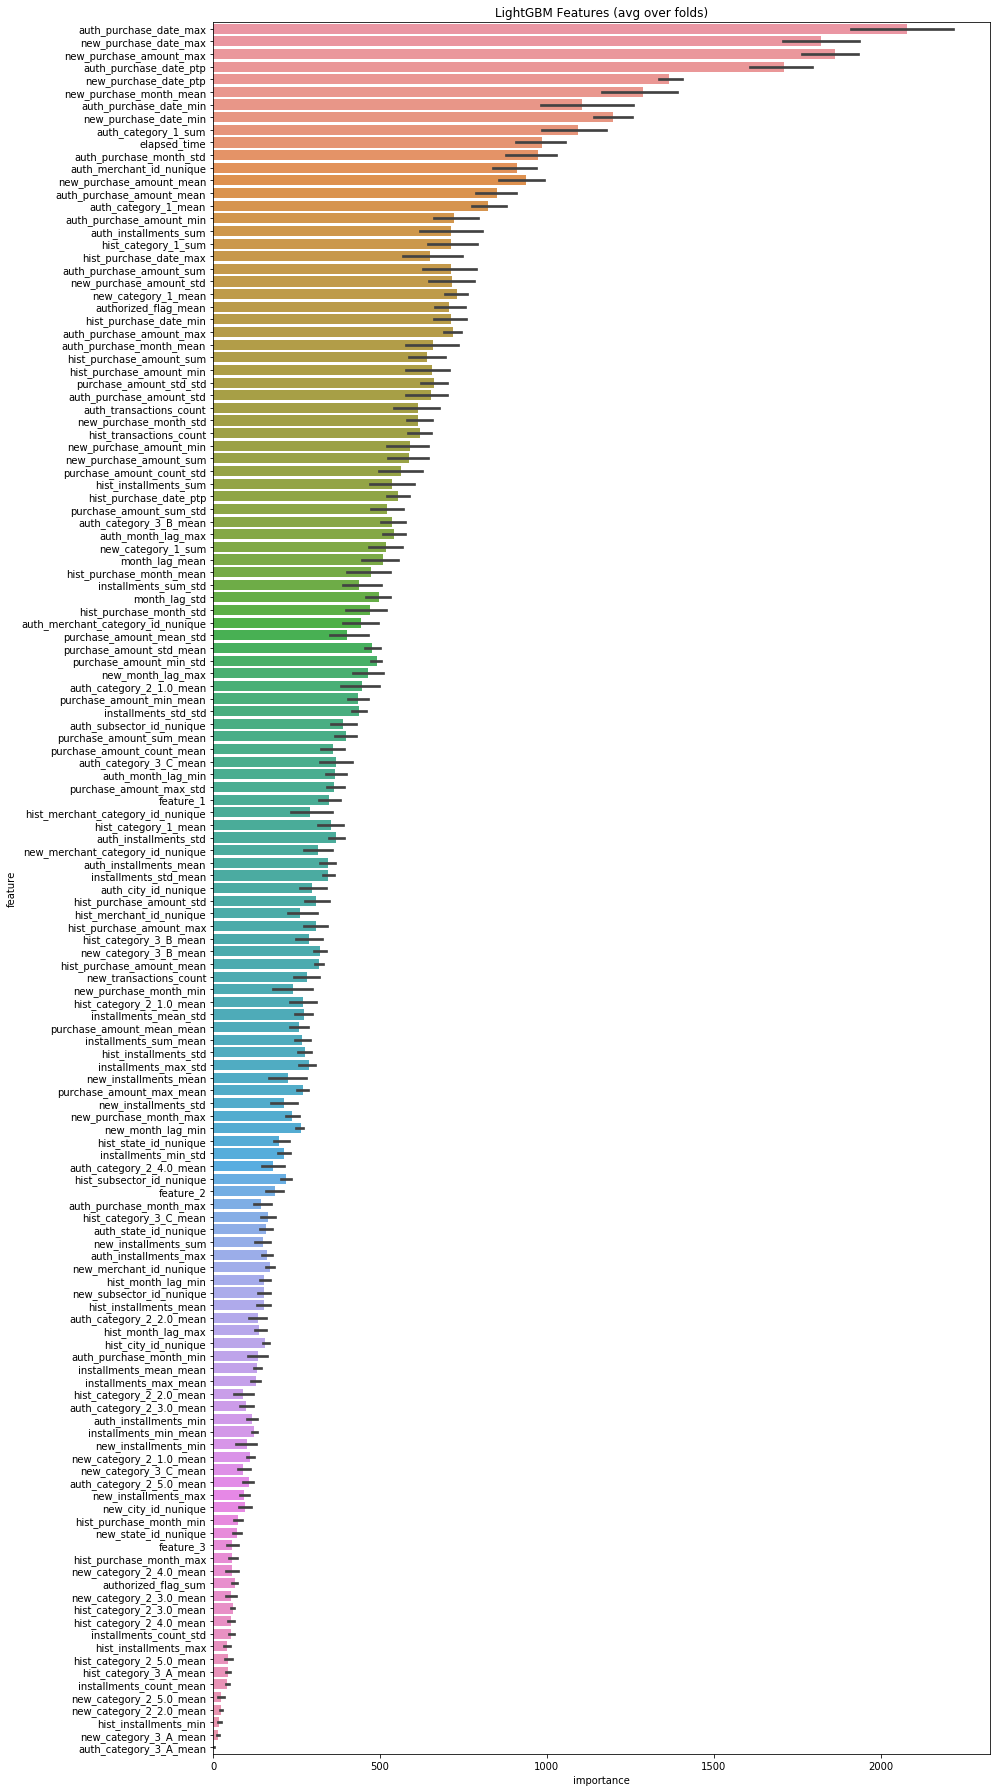

In [57]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

## LightGBM-1 with Repeated kfold approach

#### RepeatedKFold repeats K-Fold n times. It can be used when one requires to run KFold n times, producing different splits in each repetition.

In [58]:
lgbparam = {'num_leaves': 31,
            'boosting_type': 'rf',
             'min_data_in_leaf': 30, 
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.01,
             "min_child_samples": 20,
             "boosting": "gbdt",
             "feature_fraction": 0.9,
             "bagging_freq": 1,
             "bagging_fraction": 0.9 ,
             "bagging_seed": 11,
             "metric": 'rmse',
             "lambda_l1": 0.1,
             "verbosity": -1,
             "nthread": 4,
             "random_state": 4590}

In [59]:
from sklearn.model_selection import RepeatedKFold
folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=4520)

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 11000
    clf = lgb.train(lgbparam, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 100)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / (5 * 2)

print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))

fold n°0


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67318	valid_1's rmse: 3.74595
[200]	training's rmse: 3.59216	valid_1's rmse: 3.71949
[300]	training's rmse: 3.53748	valid_1's rmse: 3.70728
[400]	training's rmse: 3.49722	valid_1's rmse: 3.70178
[500]	training's rmse: 3.46457	valid_1's rmse: 3.69814
[600]	training's rmse: 3.43719	valid_1's rmse: 3.69627
[700]	training's rmse: 3.41295	valid_1's rmse: 3.69462
[800]	training's rmse: 3.39005	valid_1's rmse: 3.69401
[900]	training's rmse: 3.36902	valid_1's rmse: 3.69416
Early stopping, best iteration is:
[822]	training's rmse: 3.38552	valid_1's rmse: 3.69393
fold n°1


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.70799	valid_1's rmse: 3.60903
[200]	training's rmse: 3.63021	valid_1's rmse: 3.57665
[300]	training's rmse: 3.57735	valid_1's rmse: 3.56223
[400]	training's rmse: 3.5378	valid_1's rmse: 3.55297
[500]	training's rmse: 3.50606	valid_1's rmse: 3.54763
[600]	training's rmse: 3.47866	valid_1's rmse: 3.54347
[700]	training's rmse: 3.45428	valid_1's rmse: 3.5409
[800]	training's rmse: 3.43196	valid_1's rmse: 3.53942
[900]	training's rmse: 3.41121	valid_1's rmse: 3.5387
[1000]	training's rmse: 3.39169	valid_1's rmse: 3.53785
[1100]	training's rmse: 3.37262	valid_1's rmse: 3.53731
[1200]	training's rmse: 3.35462	valid_1's rmse: 3.53676
[1300]	training's rmse: 3.33711	valid_1's rmse: 3.53588
[1400]	training's rmse: 3.32031	valid_1's rmse: 3.53578
[1500]	training's rmse: 3.30431	valid_1's rmse: 3.53584
Early stopping, best iteration is:
[1449]	training's rmse: 3.31224	valid_1's rmse: 3.5354
fold n°2


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.63843	valid_1's rmse: 3.89346
[200]	training's rmse: 3.55939	valid_1's rmse: 3.86269
[300]	training's rmse: 3.50763	valid_1's rmse: 3.84852
[400]	training's rmse: 3.46922	valid_1's rmse: 3.84078
[500]	training's rmse: 3.43711	valid_1's rmse: 3.83628
[600]	training's rmse: 3.40912	valid_1's rmse: 3.83434
[700]	training's rmse: 3.38459	valid_1's rmse: 3.83209
[800]	training's rmse: 3.36147	valid_1's rmse: 3.83071
[900]	training's rmse: 3.34175	valid_1's rmse: 3.83035
[1000]	training's rmse: 3.3227	valid_1's rmse: 3.82937
[1100]	training's rmse: 3.30377	valid_1's rmse: 3.82848
[1200]	training's rmse: 3.28653	valid_1's rmse: 3.82841
[1300]	training's rmse: 3.26888	valid_1's rmse: 3.82836
Early stopping, best iteration is:
[1276]	training's rmse: 3.27294	valid_1's rmse: 3.8282
fold n°3


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68029	valid_1's rmse: 3.72178
[200]	training's rmse: 3.6015	valid_1's rmse: 3.69238
[300]	training's rmse: 3.54754	valid_1's rmse: 3.67986
[400]	training's rmse: 3.50871	valid_1's rmse: 3.67344
[500]	training's rmse: 3.47596	valid_1's rmse: 3.66929
[600]	training's rmse: 3.44675	valid_1's rmse: 3.66616
[700]	training's rmse: 3.42127	valid_1's rmse: 3.66451
[800]	training's rmse: 3.39898	valid_1's rmse: 3.66387
[900]	training's rmse: 3.37797	valid_1's rmse: 3.6624
[1000]	training's rmse: 3.35927	valid_1's rmse: 3.66206
[1100]	training's rmse: 3.34071	valid_1's rmse: 3.66196
Early stopping, best iteration is:
[1033]	training's rmse: 3.3528	valid_1's rmse: 3.66169
fold n°4


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68914	valid_1's rmse: 3.68913
[200]	training's rmse: 3.61125	valid_1's rmse: 3.65393
[300]	training's rmse: 3.55897	valid_1's rmse: 3.6392
[400]	training's rmse: 3.52042	valid_1's rmse: 3.63079
[500]	training's rmse: 3.48798	valid_1's rmse: 3.62559
[600]	training's rmse: 3.46184	valid_1's rmse: 3.62139
[700]	training's rmse: 3.43676	valid_1's rmse: 3.61844
[800]	training's rmse: 3.41462	valid_1's rmse: 3.61667
[900]	training's rmse: 3.39446	valid_1's rmse: 3.61606
[1000]	training's rmse: 3.37468	valid_1's rmse: 3.61514
[1100]	training's rmse: 3.35771	valid_1's rmse: 3.61456
[1200]	training's rmse: 3.33948	valid_1's rmse: 3.61453
Early stopping, best iteration is:
[1149]	training's rmse: 3.34885	valid_1's rmse: 3.61433
fold n°5


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.66242	valid_1's rmse: 3.78435
[200]	training's rmse: 3.58178	valid_1's rmse: 3.75836
[300]	training's rmse: 3.52939	valid_1's rmse: 3.74862
[400]	training's rmse: 3.48984	valid_1's rmse: 3.74264
[500]	training's rmse: 3.45598	valid_1's rmse: 3.73827
[600]	training's rmse: 3.42855	valid_1's rmse: 3.73563
[700]	training's rmse: 3.40316	valid_1's rmse: 3.73347
[800]	training's rmse: 3.38135	valid_1's rmse: 3.73213
[900]	training's rmse: 3.36042	valid_1's rmse: 3.73163
[1000]	training's rmse: 3.34143	valid_1's rmse: 3.7311
[1100]	training's rmse: 3.32364	valid_1's rmse: 3.73115
Early stopping, best iteration is:
[1036]	training's rmse: 3.33476	valid_1's rmse: 3.73086
fold n°6


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67855	valid_1's rmse: 3.72279
[200]	training's rmse: 3.5986	valid_1's rmse: 3.69428
[300]	training's rmse: 3.54499	valid_1's rmse: 3.68336
[400]	training's rmse: 3.50532	valid_1's rmse: 3.67554
[500]	training's rmse: 3.47377	valid_1's rmse: 3.67018
[600]	training's rmse: 3.44726	valid_1's rmse: 3.66637
[700]	training's rmse: 3.42282	valid_1's rmse: 3.66414
[800]	training's rmse: 3.40127	valid_1's rmse: 3.66291
[900]	training's rmse: 3.38104	valid_1's rmse: 3.66263
[1000]	training's rmse: 3.36207	valid_1's rmse: 3.66175
[1100]	training's rmse: 3.34313	valid_1's rmse: 3.66141
[1200]	training's rmse: 3.3252	valid_1's rmse: 3.66112
[1300]	training's rmse: 3.30844	valid_1's rmse: 3.66114
Early stopping, best iteration is:
[1281]	training's rmse: 3.31136	valid_1's rmse: 3.66086
fold n°7


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.67568	valid_1's rmse: 3.75187
[200]	training's rmse: 3.59841	valid_1's rmse: 3.71507
[300]	training's rmse: 3.54626	valid_1's rmse: 3.70036
[400]	training's rmse: 3.50739	valid_1's rmse: 3.69313
[500]	training's rmse: 3.47629	valid_1's rmse: 3.68868
[600]	training's rmse: 3.44885	valid_1's rmse: 3.68579
[700]	training's rmse: 3.42521	valid_1's rmse: 3.68376
[800]	training's rmse: 3.40298	valid_1's rmse: 3.68304
[900]	training's rmse: 3.38215	valid_1's rmse: 3.68233
[1000]	training's rmse: 3.36197	valid_1's rmse: 3.6816
Early stopping, best iteration is:
[975]	training's rmse: 3.36724	valid_1's rmse: 3.68144
fold n°8


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.68263	valid_1's rmse: 3.71028
[200]	training's rmse: 3.60344	valid_1's rmse: 3.67983
[300]	training's rmse: 3.5495	valid_1's rmse: 3.66679
[400]	training's rmse: 3.50907	valid_1's rmse: 3.66112
[500]	training's rmse: 3.47672	valid_1's rmse: 3.65717
[600]	training's rmse: 3.44898	valid_1's rmse: 3.65513
[700]	training's rmse: 3.42342	valid_1's rmse: 3.65438
[800]	training's rmse: 3.40061	valid_1's rmse: 3.65355
[900]	training's rmse: 3.37946	valid_1's rmse: 3.65336
Early stopping, best iteration is:
[869]	training's rmse: 3.38571	valid_1's rmse: 3.65297
fold n°9


/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 100 rounds.
[100]	training's rmse: 3.69173	valid_1's rmse: 3.68395
[200]	training's rmse: 3.61341	valid_1's rmse: 3.64948
[300]	training's rmse: 3.56051	valid_1's rmse: 3.63389
[400]	training's rmse: 3.52097	valid_1's rmse: 3.62499
[500]	training's rmse: 3.4897	valid_1's rmse: 3.61965
[600]	training's rmse: 3.46337	valid_1's rmse: 3.61622
[700]	training's rmse: 3.43916	valid_1's rmse: 3.61367
[800]	training's rmse: 3.41726	valid_1's rmse: 3.61191
[900]	training's rmse: 3.3972	valid_1's rmse: 3.61082
[1000]	training's rmse: 3.3774	valid_1's rmse: 3.61006
[1100]	training's rmse: 3.35922	valid_1's rmse: 3.60892
[1200]	training's rmse: 3.34192	valid_1's rmse: 3.60838
[1300]	training's rmse: 3.3251	valid_1's rmse: 3.60831
[1400]	training's rmse: 3.30858	valid_1's rmse: 3.60788
[1500]	training's rmse: 3.29239	valid_1's rmse: 3.60788
[1600]	training's rmse: 3.27699	valid_1's rmse: 3.60737
[1700]	training's rmse: 3.26144	valid_1's rmse: 3.6069

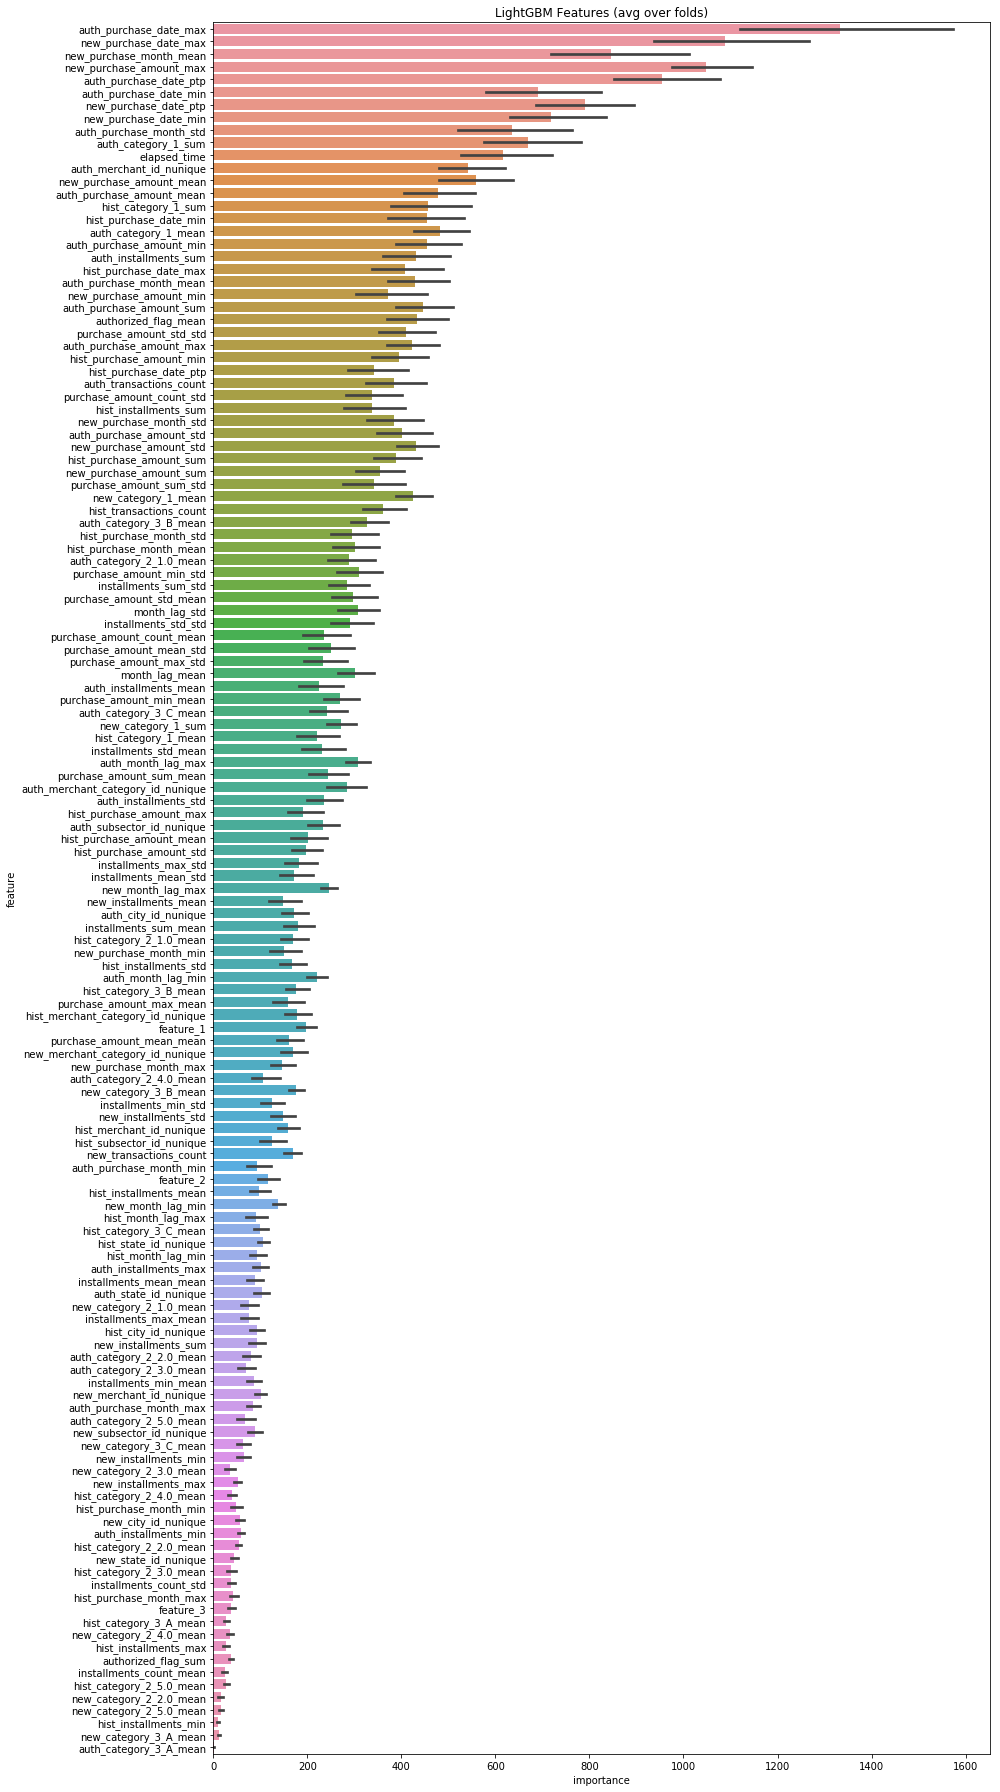

In [60]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [61]:
sub_df = pd.DataFrame({"card_id":test["card_id"].values})
sub_df["target"] = predictions
sub_df.to_csv("submit_lgb.csv", index=False)

sub_df1 = pd.DataFrame({"card_id":test["card_id"].values})
sub_df1["target"] = predictions_lgb
sub_df1.to_csv("submit_lgb1.csv", index=False)

## Stacking

In [62]:
train_stack = np.vstack([oof,oof_lgb]).transpose()
test_stack = np.vstack([predictions,predictions_lgb]).transpose()

folds = RepeatedKFold(n_splits=5,n_repeats=1,random_state=4520)
oof_stack = np.zeros(train_stack.shape[0])
predictions_stack = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, target)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    print("-" * 10 + "Stacking " + str(fold_) + "-" * 10)
#     cb_model = CatBoostRegressor(iterations=3000, learning_rate=0.1, depth=8, l2_leaf_reg=20, bootstrap_type='Bernoulli',  eval_metric='RMSE', metric_period=50, od_type='Iter', od_wait=45, random_seed=17, allow_writing_files=False)
#     cb_model.fit(trn_data, trn_y, eval_set=(val_data, val_y), cat_features=[], use_best_model=True, verbose=True)
    clf = BayesianRidge()
    clf.fit(trn_data, trn_y)
    
    oof_stack[val_idx] = clf.predict(val_data)
    predictions_stack += clf.predict(test_stack) / 5


np.sqrt(mean_squared_error(target.values, oof_stack))

fold n°0
----------Stacking 0----------
fold n°1
----------Stacking 1----------
fold n°2
----------Stacking 2----------
fold n°3
----------Stacking 3----------
fold n°4
----------Stacking 4----------


3.665490110415435

In [63]:
sample_submission = pd.read_csv('../input/elo-merchant-category-recommendation/sample_submission.csv')
sample_submission['target'] = predictions_stack
sample_submission.to_csv('Bayesian_Ridge_Stacking.csv', index=False)

In [64]:
sample_submission = pd.read_csv('../input/elo-merchant-category-recommendation/sample_submission.csv')
sample1 = pd.read_csv("../input/elo-blending/3.695.csv")
sample2 = pd.read_csv("../input/elo-blending/combining_submission (1).csv")
sample_submission['target'] = predictions * 0.5 + predictions_lgb * 0.5
sample_submission.to_csv("Blend1.csv", index = False)
sample_submission['target'] = sample_submission['target'] * 0.2 + sample1['target'] * 0.2 + sample2['target'] * 0.6
sample_submission.to_csv('Blend2.csv', index=False)